In [1]:
import os
os.chdir('../')

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white')

In [2]:
data = pd.read_csv('inference_feat.csv')
data['error'] = data['true_ef'] - data['predicted_ef']
test = data[ data['split'] == 'TEST' ].copy()

In [3]:
features = ['volume_ratio', 'length_ratio', 'dice_overlap_std']

In [5]:
reg = joblib.load('artifacts/e-predictor:v0/gbr.joblib')

X_test = test[features]
y_test = test['error']

y_pred = reg.predict(X_test)

In [6]:
test.loc[:, 'corrected_ef'] = test['predicted_ef'] + y_pred

- Heart Failure with Reduced Ejection Fraction (HFrEF): LVEF ≤40%.   

- Heart Failure with Mid-Range Ejection Fraction (HFmrEF): LVEF 41-49%.   

- Heart Failure with Preserved Ejection Fraction (HFpEF): LVEF ≥50%. (Note: A clinical diagnosis of HFpEF also requires symptoms/signs of heart failure)

- Heart Failure with Improved Ejection Fraction (HFimpEF): Defined as a previous LVEF ≤40% that has improved to >40%. (Note: clinical diagnosis needed)  

- Normal Ejection Fraction: Typically 50-70%. Some sources provide slightly more precise ranges, such as 52-72% for males and 54-74% for females. (define here as 50-74%)   

- Hypertrophic Cardiomyopathy (HCM): Characterized by unexplained left ventricular hypertrophy with a preserved or even increased ejection fraction, often above the normal range (>75%).   



Due to HFpEF and HFimpEF both require medical assessment, futher analysis will be done on all restant classifications

In [7]:
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100 

In [8]:
test['true_ef'] = test['true_ef'].round().astype(int)
test['predicted_ef'] = test['predicted_ef'].round().astype(int)
test['corrected_ef'] = test['corrected_ef'].round().astype(int)

In [9]:
def clasif_ef(ef):
    if ef > 75:
        return "Hypertrophic CM"
    elif ef >= 50:
        return "Normal EF"
    elif ef >= 41:
        return "HFmrEF"
    else:
        return "HFrEF"

In [10]:
test['clasif_true'] = test['true_ef'].apply(clasif_ef)
test['clasif_orig'] = test['predicted_ef'].apply(clasif_ef)
test['clasif_corr'] = test['corrected_ef'].apply(clasif_ef)

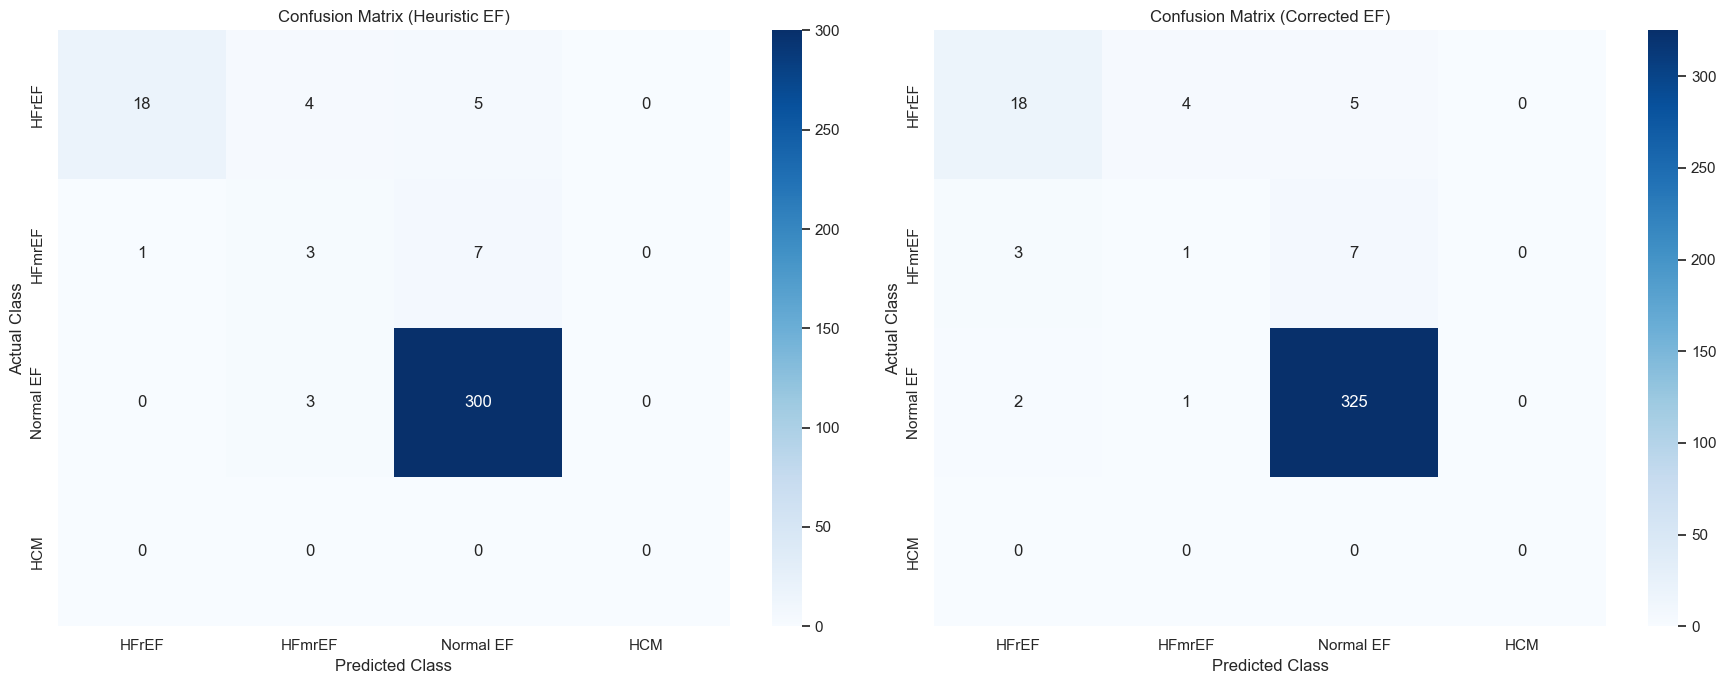

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(18, 7))

classes = ["HFrEF", "HFmrEF", "Normal EF", "HCM"]

for i, method in enumerate(['clasif_orig', 'clasif_corr']):
    cm = confusion_matrix(test['clasif_true'], test[method], labels=classes)
    
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[i], cmap='Blues', xticklabels=classes, yticklabels=classes)
    
    title_suffix = "Heuristic EF" if method == 'clasif_orig' else "Corrected EF"
    ax[i].set_title(f'Confusion Matrix ({title_suffix})')
    ax[i].set_xlabel('Predicted Class')
    ax[i].set_ylabel('Actual Class')

plt.tight_layout()
plt.show()

"Hypertrophic CM" in both the "Original EF" and "Corrected EF" confusion matrices, has all values in zero. This indicates that the test dataset contains no true positive cases for this category (no patients with EF > 75%).

In [13]:
count = 0

for ef in test['true_ef']:
    if ef > 75:
        count += 1

print(count)

0


 ROC curve analysis for this specific classification task cannot be meaningfully generated ._.

ROC curve analysis, is inherently a binary classification tool, so we define "positive" and "negative" classes for each evaluation. Based on the classifications above, the most relevant classification tasks are:
1. HFrEF vs. Non-HFrEF:
- Positive Class : LVEF ≤40%
- NEgative Class : LVEF > 40%

2. HFmrEF vs. Non-HFmrEF
- Positive Class: LVEF 41-49%
- Negative Class: LVEF <41% or >49%

3. Normal EF vs. Abnormal EF:
- Positive Class: LVEF 50-70% 
- Negative Class: LVEF <50% or >74%

In [23]:
epsilon = 1e-6
max_abs_dev_hfmref = max(
    np.abs(test['predicted_ef'] - 45).max(),
    np.abs(test['corrected_ef'] - 45).max(),
    epsilon
)
max_abs_dev_normal = max(
    np.abs(test['predicted_ef'] - 62).max(),
    np.abs(test['corrected_ef'] - 62).max(),
    epsilon
)


roc_tasks = {
    "HFrEF vs. Non-HFrEF (EF <=40%)": {
        "y_true_func": lambda ef: (ef <= 40).astype(int),
        "score_transform": lambda ef: 100 - ef,
        "optimal_threshold_label_func": lambda score: f'Optimal (EF: {100 - score:.1f})'
    },
    "HFmrEF vs. Non-HFmrEF (EF 41-49%)": {
        "y_true_func": lambda ef: ((ef >= 41) & (ef <= 49)).astype(int),
        "score_transform": lambda ef: 1 - (np.abs(ef - 45) / max_abs_dev_hfmref), 
        "optimal_threshold_label_func": lambda score: f'Optimal (Score: {score:.2f})' 
    },
    "Normal EF vs. Abnormal EF (EF 50-74%)": {
        "y_true_func": lambda ef: ((ef >= 50) & (ef <= 74)).astype(int),
        "score_transform": lambda ef: 1 - (np.abs(ef - 62) / max_abs_dev_normal), 
        "optimal_threshold_label_func": lambda score: f'Optimal (Score: {score:.2f})'
    }
}

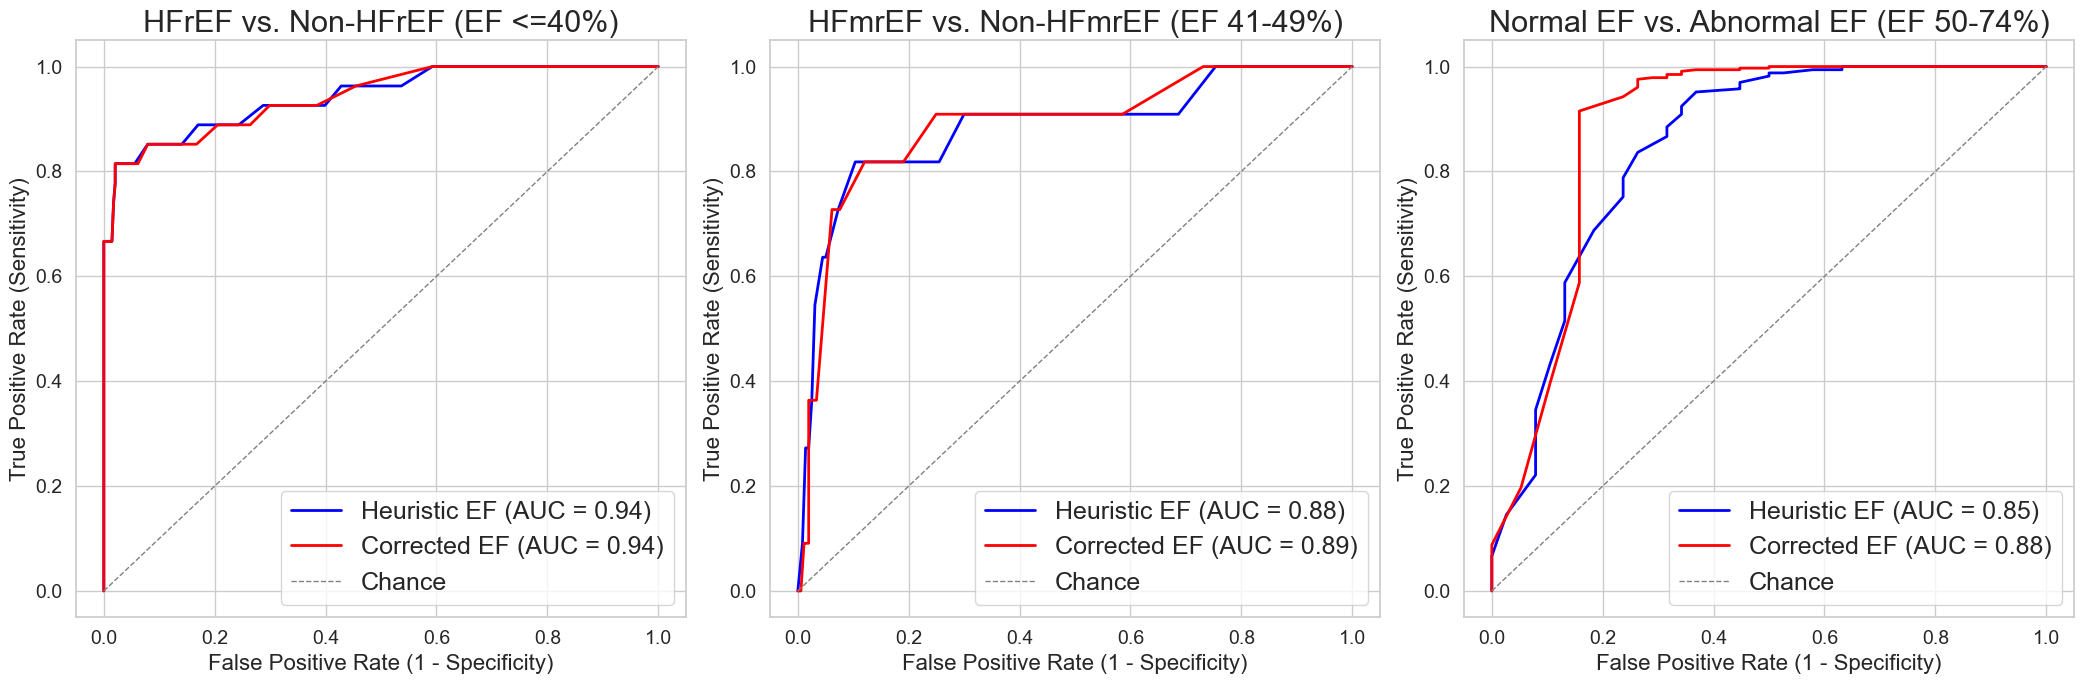

In [26]:
from sklearn.metrics import roc_curve, auc


fig, axes = plt.subplots(1, len(roc_tasks), figsize=(7 * len(roc_tasks), 7))
if len(roc_tasks) == 1: 
    axes = [axes]

for i, (task_name, task_params) in enumerate(roc_tasks.items()):
    ax = axes[i]

    y_true_binary = task_params["y_true_func"](test['true_ef'])
    y_score_orig = task_params["score_transform"](test['predicted_ef'])
    y_score_corr = task_params["score_transform"](test['corrected_ef'])

    fpr_orig, tpr_orig, _ = roc_curve(y_true_binary, y_score_orig)
    roc_auc_orig = auc(fpr_orig, tpr_orig)

    fpr_corr, tpr_corr, _ = roc_curve(y_true_binary, y_score_corr)
    roc_auc_corr = auc(fpr_corr, tpr_corr)

    ax.plot(fpr_orig, tpr_orig, color='blue', lw=2, label=f'Heuristic EF (AUC = {roc_auc_orig:.2f})')
    ax.plot(fpr_corr, tpr_corr, color='red', lw=2, label=f'Corrected EF (AUC = {roc_auc_corr:.2f})')
    ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')

    ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=16)
    ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=16)
    ax.set_title(f'{task_name}', fontsize=22)
    ax.legend(loc='lower right', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True)

plt.tight_layout()
plt.show()

Cohen's Kappa is statistic used to measure the agreement between raters and the true classifications. It accounts for the possibility of agreement occurring by chance.

In [18]:
from sklearn.metrics import  cohen_kappa_score

kappa_orig = cohen_kappa_score(test['clasif_true'], test['clasif_orig'])
kappa_corr = cohen_kappa_score(test['clasif_true'], test['clasif_corr'])

In [19]:
kappa_orig

0.4568009798687227

In [20]:
kappa_corr

0.6246015216559697

The increase in Cohen's Kappa from 0.4568 to 0.6246 demonstrates that the regression model significantly improves the agreement between the predicted EF classifications and the true clinical classifications. 